In [234]:
import pandas
import pandas as pd
from pandas import DataFrame as df
import pickle
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score # Jaccard score
from sklearn.metrics.pairwise import cosine_similarity # Cosine score
import numpy as np
from rdkit.Chem import AllChem as Chem
import rdkit.Chem
from rdkit import DataStructs
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

Purpose: The purpose of this experiment is to interpret the metaspace results from Lachlan.  These results are based upon searching 14x datasets with the filters 5x filters and their combinations that I generated for predicting nuetral losses from alcohols and carboxylic acids using RD kit.  The desired out put of this experiment would be a) identifying a filter that provides the optimal predictions for water loss, and b) discovering that using said filter improves results versus not using it.

Description from Lachlan:

"Here are annotation stats extracted from 13 HeLa cell, human and mouse datasets, with a mixture of positive & negative mode, from our MALDI. nl_stats.pickle contains one row per formula and adduct, but combining no-loss and -H2O annotations into the same row when both are present. These are the columns:

• hmdb_ids - HMDB IDs associated with this formula, for matching against your data

• msm,fdr,off_sample,intensity_avg - METASPACE statistics for the no-neutral-loss annotation (if detected)

• msm_H2O,fdr_H2O,off_sample_H2O,intensity_avg_H2O The same statistics for the -H2O annotation (if detected)

• has_matching_loss - True if both the no-loss and -H2O forms of the molecule were detected, just for making filtering easier

• colocalization - colocalization score between the no-loss and -H2O ion images, using our "median filtered cosine similarity" algorithm. The higher the value, the better the colocalization. This is a good indicator of whether the no-loss and -H2O molecules are the same molecule

• loss_intensity_ratio - ratio between the average per-pixel intensity of the -H2O annotation and the no-loss annotation. 0 if there is no -H2O annotation, infinity if there is only the -H2O annotation

datasets.pickle contains information (polarity, organism, organism part) about each dataset

This only includes annotations with an FDR up to 20%. At FDR<=50% more than half of molecules that had both no-loss and -H2O annotations didn't colocalize well (colocalization < 0.5), implying there was more noise than signal. At 20% FDR cutoff roughly 73% colocalize well, and at 10% FDR cutoff, 90% colocalize well, so if you're not getting good results, try again with the filter (nl_stats.fdr < 0.1) & (nl_stats.fdr_H2O < 0.1).

Also, there is a 14th dataset included in there to be aware of - amino acid standards in gelatin (ds_id == '2019-08-16_18h44m00s'). It has a lot of good-looking annotations, so if you want to look at the results one-by-one it may be a good place to start

Hopefully you can still get some good stats out despite many formulas mapping to multiple HMDB IDs. I've had a similar issue in the past when I've had to assign specific molecular classes to annotations, and I found that even though it looks a bit hopeless when you see how many isobaric molecules could be behind an annotation, actually the majority of annotations have extremely similar candidate molecules, often all belonging to the same molecular class.

Hopefully the same will hold true for the presence of functional groups."

In [235]:
nl_stats_df = pd.read_pickle('nl_stats.pickle')

In [236]:
data_sets = list(nl_stats_df['ds_id'].unique())

How to handle multiple ID's?  Options:
A. Treat each id as discrete and real.
B. Only handle single ID's
C. Handle each seperately
D. Something else more complicated?

1. First analyze rows with single identifcation
2. Split data into positive and negative mode

In [237]:
nl_one_id_df = nl_stats_df[nl_stats_df['hmdb_ids'].str.len() == 1]

In [238]:
def check_polarity(adduct):
    if adduct == '-H' or adduct == '+Cl':
        return 'negative'
    elif adduct == '+H' or adduct == '+Na' or adduct == '+K':
        return 'positive'
    else:
        return 'unknown'

In [239]:
nl_one_id_df.loc[:,'adduct'].apply(lambda row: check_polarity(row))

1      negative
2      negative
4      negative
8      negative
11     negative
         ...   
378    positive
384    positive
386    positive
387    positive
389    positive
Name: adduct, Length: 2388, dtype: object

In [240]:
nl_one_id_df.loc[:,'polarity'] = nl_one_id_df.loc[:,'adduct'].apply(lambda row: check_polarity(row))

/Users/dis/anaconda3/envs/lcenv/lib/python3.6/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/dis/anaconda3/envs/lcenv/lib/python3.6/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [241]:
nl_one_id_pos_df = nl_one_id_df[nl_one_id_df.polarity == 'positive'].copy(deep=True)

In [242]:
nl_one_id_pos_df.adduct.unique()

array(['+Na', '+H', '+K'], dtype=object)

In [243]:
nl_one_id_neg_df = nl_one_id_df[nl_one_id_df.polarity == 'negative'].copy(deep=True)

In [244]:
nl_one_id_neg_df.adduct.unique()

array(['-H', '+Cl'], dtype=object)

In [245]:
len(nl_one_id_pos_df)

1379

In [246]:
len(nl_one_id_neg_df)

1009

In [247]:
nl_one_id_pos_df = nl_one_id_pos_df.sort_values(by='hmdb_ids')

In [248]:
nl_one_id_neg_df = nl_one_id_neg_df.sort_values(by='hmdb_ids')

In [249]:
nl_one_id_neg_df.head(5)

,formula,adduct,msm,fdr,off_sample,hmdb_ids,intensity_avg,msm_H2O,fdr_H2O,off_sample_H2O,intensity_avg_H2O,has_matching_loss,colocalization,ds_id,loss_intensity_ratio,polarity
96,C5H5N5,-H,0.232332,0.20,False,[HMDB0000034],571.879050,NaN,NaN,NaN,NaN,False,0.0,2018-10-29_11h02m58s,0.0,negative
38,C5H5N5,-H,0.123291,0.05,True,[HMDB0000034],882.916069,NaN,NaN,NaN,NaN,False,0.0,2019-09-19_16h54m19s,0.0,negative
59,C5H5N5,-H,0.356987,0.20,True,[HMDB0000034],895.155316,NaN,NaN,NaN,NaN,False,0.0,2019-06-14_15h52m24s,0.0,negative
27,C5H5N5,-H,0.732164,0.05,False,[HMDB0000034],5263.777645,NaN,NaN,NaN,NaN,False,0.0,2019-09-13_11h37m35s,0.0,negative
286,C8H20NO6P,-H,0.085544,0.20,True,[HMDB0000086],643.974221,NaN,NaN,NaN,NaN,False,0.0,2019-09-13_11h37m35s,0.0,negative


Issues:
1. Single ID can be observed multiple times across sets or with multiple adducts.
    1009 rows negative, with 
2. Should each observation be treated sepearately?
    2.1. Is analyte behavior always the same or not?
    2.2. Loss intensity ratio = 
        'inf' if only minus water
        0 if only parent
        0 < X < inf if both
        
Operations:
    1. make new observation column:
        any_loss:
            T for 'inf' or 0 < X < inf
            F for 0
        loss_wparent:
            T for 0 < X < inf
            F for 'inf' or 0
    

In [250]:
nl_one_id_neg_df['id'] = nl_one_id_neg_df.hmdb_ids.map(lambda x: x[0])

In [251]:
nl_one_id_pos_df['id'] = nl_one_id_pos_df.hmdb_ids.map(lambda x: x[0])

In [252]:
nl_neg = nl_one_id_neg_df.drop(columns=['hmdb_ids']).copy(deep=True).rename(columns={'loss_intensity_ratio':'lir'})

In [253]:
nl_pos = nl_one_id_pos_df.drop(columns=['hmdb_ids']).copy(deep=True).rename(columns={'loss_intensity_ratio':'lir'})

In [254]:
def any_loss(data):
    if data > 0.000000:
        return(True)
    else:
        return(False)
    
def loss_wparent(data):
    if float(data) < 0.0000001:
        return(False)
    elif float(data) > 10000:
        return(False)
    else:
        return(True)

In [255]:
nl_neg.loc[:,'any_loss'] = nl_neg.apply(lambda x: any_loss(x['lir']), axis=1)
nl_neg.loc[:,'loss_wparent'] = nl_neg.apply(lambda x: loss_wparent(x['lir']), axis=1)

nl_pos.loc[:,'any_loss'] = nl_pos.apply(lambda x: any_loss(x['lir']), axis=1)
nl_pos.loc[:,'loss_wparent'] = nl_pos.apply(lambda x: loss_wparent(x['lir']), axis=1)

Metaspace df's for positive and negative are now cleaned up, and ready to go, with boolean annotations of experimental water losses in 'any_loss' and 'loss_wparent' to compare with theoretical predictions.  Index's will be be joined along 'id'.

In [256]:
hmdb_structures_CA_OH = pandas.read_pickle('hmdb_structures_CA_OH.pickle')

Here are all the ID's that were only observed 1x in the negative or positive datasets:

In [257]:
observed_neg_1x_id = list(nl_neg.id.unique())
observed_pos_1x_id = list(nl_pos.id.unique())

df.isin let's you sort a dataframe by values in a list: 

In [258]:
water_preds_neg = hmdb_structures_CA_OH[hmdb_structures_CA_OH['id'].isin(observed_neg_1x_id)]
water_preds_pos = hmdb_structures_CA_OH[hmdb_structures_CA_OH['id'].isin(observed_pos_1x_id)]

Okay, let's join the positive and negative dataframe and the prediction data-frame:

In [259]:
join_neg_df = pd.merge(nl_neg, water_preds_neg, left_on="id", right_on="id", how="left", validate="m:1").copy(deep=True)

In [260]:
join_pos_df = pd.merge(nl_pos, water_preds_pos, left_on="id", right_on="id", how="left", validate="m:1").copy(deep=True)

In [261]:
headers = hmdb_structures_CA_OH.columns

In [262]:
heads = list(headers.drop('id'))

In [263]:
heads

['a_CA',
 'b_CA',
 'c_CA',
 'd_OH',
 'e_OH',
 'a_CA-b_CA',
 'a_CA-c_CA',
 'a_CA-d_OH',
 'a_CA-e_OH',
 'b_CA-c_CA',
 'b_CA-d_OH',
 'b_CA-e_OH',
 'c_CA-d_OH',
 'c_CA-e_OH',
 'd_OH-e_OH',
 'a_CA-b_CA-c_CA',
 'a_CA-b_CA-d_OH',
 'a_CA-b_CA-e_OH',
 'a_CA-c_CA-d_OH',
 'a_CA-c_CA-e_OH',
 'a_CA-d_OH-e_OH',
 'b_CA-c_CA-d_OH',
 'b_CA-c_CA-e_OH',
 'b_CA-d_OH-e_OH',
 'c_CA-d_OH-e_OH',
 'a_CA-b_CA-c_CA-d_OH',
 'a_CA-b_CA-c_CA-e_OH',
 'a_CA-b_CA-d_OH-e_OH',
 'a_CA-c_CA-d_OH-e_OH',
 'b_CA-c_CA-d_OH-e_OH',
 'a_CA-b_CA-c_CA-d_OH-e_OH']

Let's write some functions to:
    a) loop over columns of experimental and predictions and polarity
    b) calculate Pierson coeffecients
    c) calculate Jaccard similarity
    d) calculate cosine similarity

In [264]:
'''
out_neg_df = pd.DataFrame(columns=['df_in_id', 
                                   'df_out_id', 
                                   'fdr', 
                                   'colocal_thres'
                                   'compare_meth',
                                   'exp_targ', 
                                   'theo_targ',
                                   'compare'
                                   ])
out_pos_df = out_neg_df.copy(deep=True) 

df_ins = [join_pos_df, join_neg_df]
df_ins_id = ['join_pos_df', 'join_neg_df']
df_outs = [out_pos_df, out_neg_df]
df_outs_id = ['out_pos_df', 'out_neg_df']

fdr = [0.05, 0.10, 0.20]
colocal_thres = 0
compare_meth = ['Pierson', 'Jaccard', 'Cosine']

exp_targs = ['any_loss', 'loss_wparent']
theo_targs = heads

data_sets = data_sets
'''

"\nout_neg_df = pd.DataFrame(columns=['df_in_id', \n                                   'df_out_id', \n                                   'fdr', \n                                   'colocal_thres'\n                                   'compare_meth',\n                                   'exp_targ', \n                                   'theo_targ',\n                                   'compare'\n                                   ])\nout_pos_df = out_neg_df.copy(deep=True) \n\ndf_ins = [join_pos_df, join_neg_df]\ndf_ins_id = ['join_pos_df', 'join_neg_df']\ndf_outs = [out_pos_df, out_neg_df]\ndf_outs_id = ['out_pos_df', 'out_neg_df']\n\nfdr = [0.05, 0.10, 0.20]\ncolocal_thres = 0\ncompare_meth = ['Pierson', 'Jaccard', 'Cosine']\n\nexp_targs = ['any_loss', 'loss_wparent']\ntheo_targs = heads\n\ndata_sets = data_sets\n"

In [265]:
out_neg_df = pd.DataFrame(columns=['df_in_id', 
                                   'df_out_id', 
                                   'fdr', 
                                   'colocal_thres'
                                   'compare_meth',
                                   'exp_targ', 
                                   'theo_targ',
                                   'compare'
                                   ])
out_pos_df = out_neg_df.copy(deep=True) 

df_ins = [join_pos_df, join_neg_df]
df_ins_id = ['join_pos_df', 'join_neg_df']
df_outs = [out_pos_df, out_neg_df]
df_outs_id = ['out_pos_df', 'out_neg_df']

fdr = [0.05, 0.10, 0.20]
colocal_thres = 0
compare_meth = ['Jaccard']

exp_targs = ['any_loss', 'loss_wparent']
theo_targs = ['c_CA-d_OH-e_OH']

data_sets = data_sets

In [266]:
# Loop to run mr_loop over various datasets

In [267]:
def pierson_corr(df_in, exp, theo):
    theo_series = df_in[theo].astype('bool')
    exp_series = df_in[exp].astype('bool')  
    result = exp_series.corr(theo_series, method='pearson')
    return result


def jaccard_sim(df_in, exp, theo):
    theo_series = df_in[theo].astype('bool')
    theo_array = theo_series.to_numpy(copy=True)
    exp_series = df_in[exp].astype('bool')
    exp_array = exp_series.to_numpy(copy=True)
    result = jaccard_score(exp_array, theo_array, average='binary')
    return result


def cosine_sim(df_in, exp, theo):
    theo_series = df_in[theo].astype('bool')
    theo_array = theo_series.to_numpy(copy=True)
    exp_series = df_in[exp].astype('bool')
    exp_array = exp_series.to_numpy(copy=True) 
    result = cosine_similarity([theo_array], [exp_array])
    return result

In [268]:
def mr_loop(df_ins, df_ins_id, df_outs, df_outs_id,
            fdr, colocal_thres, compare_meth, 
            exp_targs, theo_targs):

    counter = 0
    out_list = []
    while counter < len(df_ins):
        df_in = df_ins[counter]
        df_in_id = df_ins_id[counter]
        df_out = df_outs[counter]
        df_out_id = df_outs_id[counter]
        
        df_in = df_in[df_in.colocalization >= colocal_thres]
        
        for f in fdr:
            df = df_in
            df = df[df.fdr <= f]
            
            for meth in compare_meth:

                if 'Pierson' == meth:
                    for exp in exp_targs:
                        for theo in theo_targs:
                            pc = pierson_corr(df, exp, theo)
                            df_out = df_out.append({'df_in_id': df_in_id, 
                                           'df_out_id': df_out_id, 
                                           'fdr': f, 
                                           'colocal_thres': colocal_thres,
                                           'compare_meth': 'Pierson',
                                           'exp_targ': exp, 
                                           'theo_targ': theo,
                                           'compare': pc                                    
                                           }, ignore_index=True)

                if 'Jaccard' == meth:
                    for exp in exp_targs:
                        for theo in theo_targs:
                            js = jaccard_sim(df, exp, theo)
                            df_out = df_out.append({'df_in_id': df_in_id, 
                                           'df_out_id': df_out_id, 
                                           'fdr': f, 
                                           'colocal_thres': colocal_thres,
                                           'compare_meth': 'Jaccard',
                                           'exp_targ': exp, 
                                           'theo_targ': theo,
                                           'compare': js                                    
                                           }, ignore_index=True)

                if 'Cosine' == meth:
                    for exp in exp_targs:
                        for theo in theo_targs:
                            cs = cosine_sim(df, exp, theo)
                            df_out = df_out.append({'df_in_id': df_in_id, 
                                           'df_out_id': df_out_id, 
                                           'fdr': f, 
                                            'colocal_thres': colocal_thres,
                                            'compare_meth': 'Cosine',
                                            'exp_targ': exp, 
                                            'theo_targ': theo,
                                            'compare': js                                    
                                            }, ignore_index=True)
        out_list.append(df_out)
        counter +=1
    
    return(out_list)

In [269]:
all_data = mr_loop(df_ins, df_ins_id, df_outs, df_outs_id,
            fdr, colocal_thres, compare_meth, 
            exp_targs, theo_targs)

In [270]:
temp_pos = join_pos_df[['id', 
                       'any_loss', 
                       'loss_wparent',
                       'c_CA-d_OH-e_OH',
                       'fdr',
                       'colocalization'
                      ]]

temp_pos = temp_pos[temp_pos.colocalization >= 0.90].copy(deep=True)

temp_neg = join_neg_df[['id', 
                       'any_loss', 
                       'loss_wparent',
                       'c_CA-d_OH-e_OH',
                       'fdr',
                       'colocalization'
                      ]]

temp_neg = temp_neg[temp_neg.colocalization >= 0.0].copy(deep=True)

In [271]:
jaccard_sim(temp_neg, 'loss_wparent', 'c_CA-d_OH-e_OH')

0.1696

In [272]:
join_pos_df.columns

Index(['formula', 'adduct', 'msm', 'fdr', 'off_sample', 'intensity_avg',
       'msm_H2O', 'fdr_H2O', 'off_sample_H2O', 'intensity_avg_H2O',
       'has_matching_loss', 'colocalization', 'ds_id', 'lir', 'polarity', 'id',
       'any_loss', 'loss_wparent', 'a_CA', 'b_CA', 'c_CA', 'd_OH', 'e_OH',
       'a_CA-b_CA', 'a_CA-c_CA', 'a_CA-d_OH', 'a_CA-e_OH', 'b_CA-c_CA',
       'b_CA-d_OH', 'b_CA-e_OH', 'c_CA-d_OH', 'c_CA-e_OH', 'd_OH-e_OH',
       'a_CA-b_CA-c_CA', 'a_CA-b_CA-d_OH', 'a_CA-b_CA-e_OH', 'a_CA-c_CA-d_OH',
       'a_CA-c_CA-e_OH', 'a_CA-d_OH-e_OH', 'b_CA-c_CA-d_OH', 'b_CA-c_CA-e_OH',
       'b_CA-d_OH-e_OH', 'c_CA-d_OH-e_OH', 'a_CA-b_CA-c_CA-d_OH',
       'a_CA-b_CA-c_CA-e_OH', 'a_CA-b_CA-d_OH-e_OH', 'a_CA-c_CA-d_OH-e_OH',
       'b_CA-c_CA-d_OH-e_OH', 'a_CA-b_CA-c_CA-d_OH-e_OH'],
      dtype='object')

In [273]:
all_data[0].to_pickle("./pos_water_loss_compare_coloc_0.pkl")
all_data[1].to_pickle("./neg_water_loss_compare_coloc_0.pkl")


In [274]:
all_data[0]

,df_in_id,df_out_id,fdr,colocal_threscompare_meth,exp_targ,theo_targ,compare,colocal_thres,compare_meth
0,join_pos_df,out_pos_df,0.05,NaN,any_loss,c_CA-d_OH-e_OH,0.355556,0.0,Jaccard
1,join_pos_df,out_pos_df,0.05,NaN,loss_wparent,c_CA-d_OH-e_OH,0.355556,0.0,Jaccard
2,join_pos_df,out_pos_df,0.10,NaN,any_loss,c_CA-d_OH-e_OH,0.357664,0.0,Jaccard
3,join_pos_df,out_pos_df,0.10,NaN,loss_wparent,c_CA-d_OH-e_OH,0.357664,0.0,Jaccard
4,join_pos_df,out_pos_df,0.20,NaN,any_loss,c_CA-d_OH-e_OH,0.201754,0.0,Jaccard
5,join_pos_df,out_pos_df,0.20,NaN,loss_wparent,c_CA-d_OH-e_OH,0.201754,0.0,Jaccard


In [275]:
pos_stock = all_data[0]
neg_stock = all_data[1]

In [276]:
def bar_plot(title, key, x_label, y1_in, y2_in, y3_in, y4_in):
    x = list(range(len(y1_in)))

    x1 = [n - 0.3 for n in x]
    x2 = [n - 0.15 for n in x]
    x3 = [n + 0.15 for n in x]
    x4 = [n + 0.15 for n in x]

    y1 = list(y1_in)
    y2 = list(y2_in)
    y3 = list(y3_in)
    y4 = list(y4_in)

    y_list_list = [y1,y2,y3,y4]

    for ylist in y_list_list:
        for yx in ylist:
            yx = float(yx)
    
    ax = plt.subplot(111)
    a1 = ax.bar(x1, y1, width=0.15, color='c', align='center' )
    a2 = ax.bar(x2, y2, width=0.15, color='b', align='center' )
    a3 = ax.bar(x3, y3, width=0.15, color='g', align='center' )
    a4 = ax.bar(x4, y4, width=0.15, color='r', align='center' )
    ax.set_ylabel('Comparison')
    ax.set_xlabel('rdkit models for detecting CO2 and OH')
    ax.legend((a1[0], a2[0], a3[0], a4[0]), tuple(key), loc='lower right')
    plt.title(title)
    plt.xticks(x, x_label)
    plt.xticks(rotation='vertical')
    plt.rcParams['figure.dpi'] = 400
    plt.show

ValueError: shape mismatch: objects cannot be broadcast to a single shape

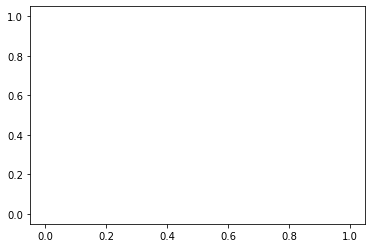

In [277]:
cur = pos_stock

title = 'Correlation method comparisons positive'
key = ['Pierson', 'Jaccard', 'Cosine', '']
x_label = list(cur['theo_targ'])
y1_in = list(cur.compare[cur.compare_meth == key[0]])
y2_in = list(cur.compare[cur.compare_meth == key[1]])
y3_in = list(cur.compare[cur.compare_meth == key[2]])
y4_in = [0]

bar_plot(title, key, x_label, y1_in, y2_in, y3_in, y4_in)

ValueError: shape mismatch: objects cannot be broadcast to a single shape

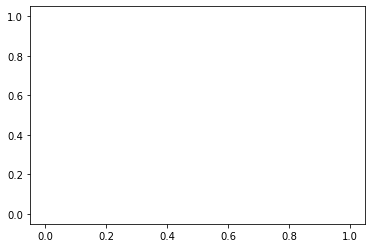

In [278]:
cur = neg_stock

title = 'Correlation method comparisons negative'
key = ['Pierson', 'Jaccard', 'Cosine', '']
x_label = list(cur['theo_targ'])
y1_in = list(cur.compare[cur.compare_meth == key[0]])
y2_in = list(cur.compare[cur.compare_meth == key[1]])
y3_in = list(cur.compare[cur.compare_meth == key[2]])
y4_in = [0]

bar_plot(title, key, x_label, y1_in, y2_in, y3_in, y4_in)

In [279]:
df_ins = [join_pos_df, join_neg_df]
df_ins_id = ['join_pos_df', 'join_neg_df']
df_outs = [out_pos_df, out_neg_df]
df_outs_id = ['out_pos_df', 'out_neg_df']

fdr = [0.20]
colocal_thres = 0
compare_meth = ['Jaccard']

exp_targs = ['any_loss', 'loss_wparent']
theo_targs = heads

data_sets = data_sets

In [280]:
all_data = mr_loop(df_ins, df_ins_id, df_outs, df_outs_id,
            fdr, colocal_thres, compare_meth, 
            exp_targs, theo_targs)

In [281]:
pos = all_data[0]
neg = all_data[1]

In [282]:
pos.head(5)

,df_in_id,df_out_id,fdr,colocal_threscompare_meth,exp_targ,theo_targ,compare,colocal_thres,compare_meth
0,join_pos_df,out_pos_df,0.2,NaN,any_loss,a_CA,0.135593,0.0,Jaccard
1,join_pos_df,out_pos_df,0.2,NaN,any_loss,b_CA,0.020000,0.0,Jaccard
2,join_pos_df,out_pos_df,0.2,NaN,any_loss,c_CA,0.136778,0.0,Jaccard
3,join_pos_df,out_pos_df,0.2,NaN,any_loss,d_OH,0.105634,0.0,Jaccard
4,join_pos_df,out_pos_df,0.2,NaN,any_loss,e_OH,0.131673,0.0,Jaccard


<function matplotlib.pyplot.show(*args, **kw)>

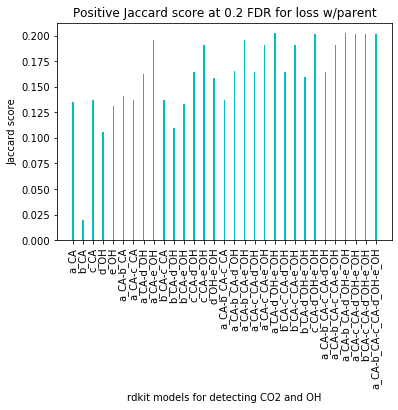

In [283]:
pos_temp = all_data[0]
pos = pos_temp[pos_temp.exp_targ == 'loss_wparent']
x1 = list(range(len(pos.compare)))
y1 = list(pos.compare)
x_label = list(pos.theo_targ)
title = 'Positive Jaccard score at 0.2 FDR for loss w/parent'

for ys in y1:
    ys = float(ys)
    
ax = plt.subplot(111)
a1 = ax.bar(x1, y1, width=0.15, color='c', align='center' )
ax.set_ylabel('Jaccard score')
ax.set_xlabel('rdkit models for detecting CO2 and OH')
plt.title(title)
plt.xticks(x1, x_label)
plt.xticks(rotation='vertical')
plt.rcParams['figure.dpi'] = 400
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

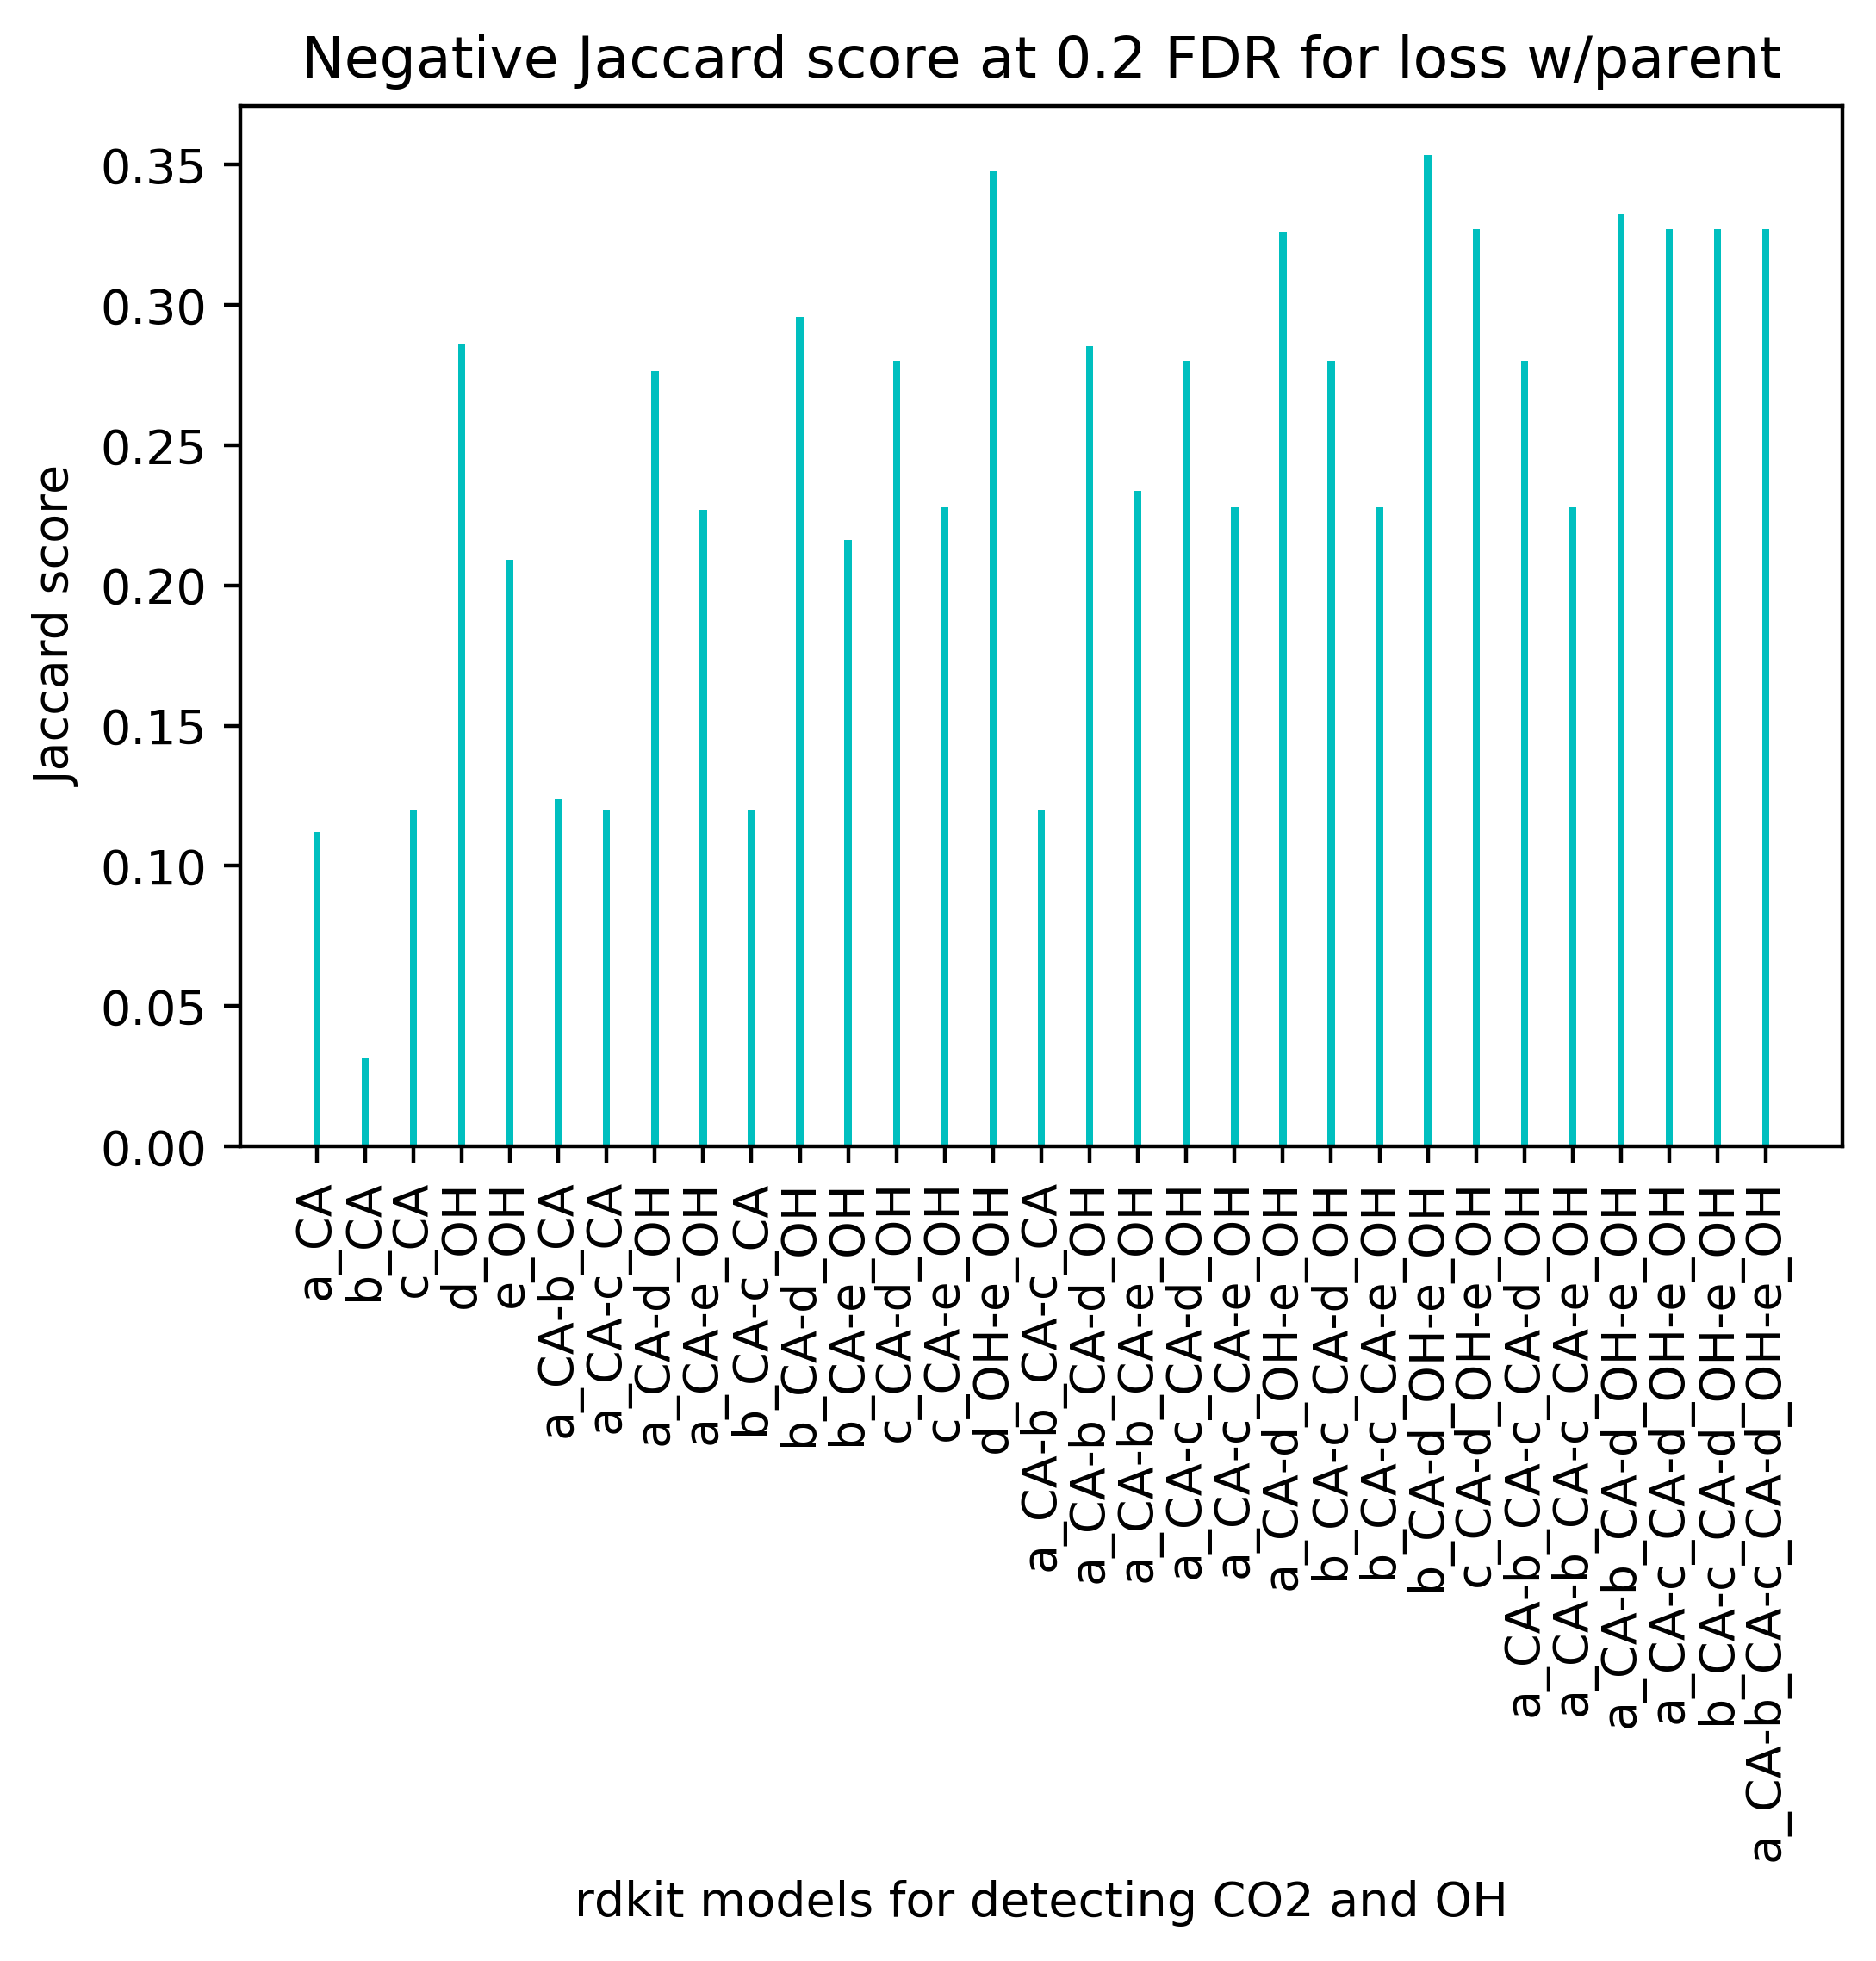

In [284]:
neg_temp = all_data[1]
neg = neg_temp[neg_temp.exp_targ == 'loss_wparent']
x1 = list(range(len(neg.compare)))
y1 = list(neg.compare)
x_label = list(neg.theo_targ)
title = 'Negative Jaccard score at 0.2 FDR for loss w/parent'

for ys in y1:
    ys = float(ys)
    
ax = plt.subplot(111)
a1 = ax.bar(x1, y1, width=0.15, color='c', align='center' )
ax.set_ylabel('Jaccard score')
ax.set_xlabel('rdkit models for detecting CO2 and OH')
plt.title(title)
plt.xticks(x1, x_label)
plt.xticks(rotation='vertical')
plt.rcParams['figure.dpi'] = 400
plt.show

In [285]:
join_pos_df.head(5)

,formula,adduct,msm,fdr,off_sample,intensity_avg,msm_H2O,fdr_H2O,off_sample_H2O,intensity_avg_H2O,...,b_CA-c_CA-d_OH,b_CA-c_CA-e_OH,b_CA-d_OH-e_OH,c_CA-d_OH-e_OH,a_CA-b_CA-c_CA-d_OH,a_CA-b_CA-c_CA-e_OH,a_CA-b_CA-d_OH-e_OH,a_CA-c_CA-d_OH-e_OH,b_CA-c_CA-d_OH-e_OH,a_CA-b_CA-c_CA-d_OH-e_OH
0,C10H16N2O3S,+H,0.322826,0.1,False,382.374341,0.36026,0.05,True,363.942389,...,True,True,False,True,True,True,True,True,True,True
1,C5H5N5,+Na,0.102210,0.2,False,77.664428,NaN,NaN,NaN,NaN,...,False,False,False,False,False,False,False,False,False,False
2,C5H5N5,+H,0.007267,0.2,True,354.010150,NaN,NaN,NaN,NaN,...,False,False,False,False,False,False,False,False,False,False
3,C8H20NO6P,+Na,0.143235,0.2,False,212.459347,NaN,NaN,NaN,NaN,...,True,False,True,True,True,False,True,True,True,True
4,C8H20NO6P,+H,0.471918,0.2,False,621.190598,NaN,NaN,NaN,NaN,...,True,False,True,True,True,False,True,True,True,True


In [286]:
join_pos_df.columns

Index(['formula', 'adduct', 'msm', 'fdr', 'off_sample', 'intensity_avg',
       'msm_H2O', 'fdr_H2O', 'off_sample_H2O', 'intensity_avg_H2O',
       'has_matching_loss', 'colocalization', 'ds_id', 'lir', 'polarity', 'id',
       'any_loss', 'loss_wparent', 'a_CA', 'b_CA', 'c_CA', 'd_OH', 'e_OH',
       'a_CA-b_CA', 'a_CA-c_CA', 'a_CA-d_OH', 'a_CA-e_OH', 'b_CA-c_CA',
       'b_CA-d_OH', 'b_CA-e_OH', 'c_CA-d_OH', 'c_CA-e_OH', 'd_OH-e_OH',
       'a_CA-b_CA-c_CA', 'a_CA-b_CA-d_OH', 'a_CA-b_CA-e_OH', 'a_CA-c_CA-d_OH',
       'a_CA-c_CA-e_OH', 'a_CA-d_OH-e_OH', 'b_CA-c_CA-d_OH', 'b_CA-c_CA-e_OH',
       'b_CA-d_OH-e_OH', 'c_CA-d_OH-e_OH', 'a_CA-b_CA-c_CA-d_OH',
       'a_CA-b_CA-c_CA-e_OH', 'a_CA-b_CA-d_OH-e_OH', 'a_CA-c_CA-d_OH-e_OH',
       'b_CA-c_CA-d_OH-e_OH', 'a_CA-b_CA-c_CA-d_OH-e_OH'],
      dtype='object')

Let's calculate TP, FP, TN, and FN!

https://kawahara.ca/how-to-compute-truefalse-positives-and-truefalse-negatives-in-python-for-binary-classification-problems/

In [287]:
obs_any_pos = np.asarray(join_pos_df.any_loss)
obs_wp_pos = np.asarray(join_pos_df.loss_wparent)

theo_pos = np.asarray(join_pos_df['c_CA-d_OH-e_OH'])

obs_any_neg = np.asarray(join_neg_df.any_loss)
obs_wp_neg = np.asarray(join_neg_df.loss_wparent)

theo_neg = np.asarray(join_neg_df['c_CA-d_OH-e_OH'])

In [288]:
def tp_tn_fp_fn(obs, theo):
    # obs = true, theo = pred
    out = {}
     
    out['tp'] = np.sum(np.logical_and(theo == 1, obs == 1))
    out['tn'] = np.sum(np.logical_and(theo == 0, obs == 0))
    out['fp'] = np.sum(np.logical_and(theo == 1, obs == 0))
    out['fn'] = np.sum(np.logical_and(theo == 0, obs == 1))
    
    out['sens'] = out['tp'] / (out['tp'] + out['fn'])
    out['spec'] = out['tn'] / (out['tn'] + out['fp'])
    out['ppv'] = out['tp'] / (out['tp'] + out['fp'])
    out['npv'] = out['tn'] / (out['tn'] + out['fn'])
    
    
    return out
    

In [289]:
any_pos = tp_tn_fp_fn(obs_any_pos, theo_pos)
any_neg = tp_tn_fp_fn(obs_any_neg, theo_neg)

wp_pos = tp_tn_fp_fn(obs_wp_pos, theo_pos)
wp_neg = tp_tn_fp_fn(obs_wp_neg, theo_neg)

In [290]:
wp_neg

{'tp': 104,
 'tn': 384,
 'fp': 466,
 'fn': 46,
 'sens': 0.6933333333333334,
 'spec': 0.45176470588235296,
 'ppv': 0.1824561403508772,
 'npv': 0.8930232558139535}

In [291]:
ds_jd ={}
target_df = join_pos_df

for dataset in list(target_df.ds_id.unique()):
    df_in = target_df[target_df.ds_id == dataset]
    exp = 'any_loss'
    theo = 'c_CA-d_OH-e_OH'

    js = jaccard_sim(df_in, exp, theo)
    ds_jd[dataset] = js

In [292]:
ds_jd

{'2019-08-16_18h44m00s': 0.5070754716981132,
 '2019-05-17_18h15m11s': 0.3838383838383838,
 '2018-09-14_10h10m06s': 0.5454545454545454,
 '2017-11-21_10h44m45s': 0.2698412698412698,
 '2019-08-28_16h39m41s': 0.24210526315789474,
 '2019-04-30_09h50m09s': 0.13114754098360656}

In [293]:
pos_df = join_pos_df[join_pos_df.ds_id == '2019-08-16_18h44m00s']
neg_df = join_neg_df[join_neg_df.ds_id == '2019-07-26_11h26m33s']

obs_any_pos = np.asarray(pos_df.any_loss)
obs_wp_pos = np.asarray(pos_df.loss_wparent)

theo_pos = np.asarray(pos_df['c_CA-d_OH-e_OH'])

obs_any_neg = np.asarray(neg_df.any_loss)
obs_wp_neg = np.asarray(neg_df.loss_wparent)

theo_neg = np.asarray(neg_df['c_CA-d_OH-e_OH'])

In [294]:
any_pos = tp_tn_fp_fn(obs_any_pos, theo_pos)
any_neg = tp_tn_fp_fn(obs_any_neg, theo_neg)

wp_pos = tp_tn_fp_fn(obs_wp_pos, theo_pos)
wp_neg = tp_tn_fp_fn(obs_wp_neg, theo_neg)

In [295]:
wp_pos

{'tp': 66,
 'tn': 222,
 'fp': 234,
 'fn': 33,
 'sens': 0.6666666666666666,
 'spec': 0.4868421052631579,
 'ppv': 0.22,
 'npv': 0.8705882352941177}

datasets.pickle contains information (polarity, organism, organism part) about each dataset

In [296]:
meta = pd.read_pickle('datasets.pickle')

In [297]:
meta.head(3)

,ds_id,name,polarity,organism,organism_part,analyzer,ionisation_source,maldi_matrix
0,2019-09-13_11h37m35s,2019-09-11_FluroSlide5_DAN_75X75_NEG,Negative,Hela cells,Cells,Orbitrap,MALDI,DAN
1,2019-07-26_11h26m33s,240719_FDA_HELA _NA_W3_DAN_NEG_190725161642,Negative,Hela cells,Cells,Orbitrap,MALDI,DAN
2,2019-07-25_16h23m17s,240719_FDA_HELA _cyto_S1_DAN_NEG,Negative,Hela cells,Cells,Orbitrap,MALDI,DAN


In [298]:
def morgan_fp(molecule):
    fp = rdkit.Chem.AllChem.GetMorganFingerprintAsBitVect(
                                    molecule, radius=2, nBits=1024)
    return fp

In [299]:
def fp_to_array(fp):
    # Convert the RDKit explicit vectors into numpy arrays
    np_fps = []
    arr = np.zeros((1,))
    rdkit.DataStructs.ConvertToNumpyArray(fp, arr)
    np_fps.append(arr)
    return np_fps

In [300]:
def molecure_fp_array(molecule):
    fp = morgan_fp(molecule)
    bits = fp_to_array(fp)
    return bits

In [301]:
# Could train secondary classifier to predict if assignment is T or F?
def confuse(obs, theo):
    o = bool(obs)
    t = bool(theo)
    if o == True and t == True:
        return 1 #TP
    elif o == False and t == False:
        return 1 #TN
    elif o == False and t == True:
        return 0 #FP
    else:
        return 0 #FN
            

In [302]:
o = 'any_loss'
t = 'c_CA-d_OH-e_OH'
join_pos_df['confuse'] = join_pos_df[[o,t]].apply(lambda x: confuse(*x), axis=1)
join_neg_df['confuse'] = join_neg_df[[o,t]].apply(lambda x: confuse(*x), axis=1)


In [303]:
# Then apply morgan and fp

In [304]:
molecules_rd = pd.read_pickle('molecules_rd')

In [305]:
pos_rd = pd.merge(join_pos_df, molecules_rd, left_on="id", right_on="id", how="left", validate="m:1").copy(deep=True)
neg_rd = pd.merge(join_neg_df, molecules_rd, left_on="id", right_on="id", how="left", validate="m:1").copy(deep=True)

In [306]:
pos_rd.columns

Index(['formula', 'adduct', 'msm', 'fdr', 'off_sample', 'intensity_avg',
       'msm_H2O', 'fdr_H2O', 'off_sample_H2O', 'intensity_avg_H2O',
       'has_matching_loss', 'colocalization', 'ds_id', 'lir', 'polarity', 'id',
       'any_loss', 'loss_wparent', 'a_CA', 'b_CA', 'c_CA', 'd_OH', 'e_OH',
       'a_CA-b_CA', 'a_CA-c_CA', 'a_CA-d_OH', 'a_CA-e_OH', 'b_CA-c_CA',
       'b_CA-d_OH', 'b_CA-e_OH', 'c_CA-d_OH', 'c_CA-e_OH', 'd_OH-e_OH',
       'a_CA-b_CA-c_CA', 'a_CA-b_CA-d_OH', 'a_CA-b_CA-e_OH', 'a_CA-c_CA-d_OH',
       'a_CA-c_CA-e_OH', 'a_CA-d_OH-e_OH', 'b_CA-c_CA-d_OH', 'b_CA-c_CA-e_OH',
       'b_CA-d_OH-e_OH', 'c_CA-d_OH-e_OH', 'a_CA-b_CA-c_CA-d_OH',
       'a_CA-b_CA-c_CA-e_OH', 'a_CA-b_CA-d_OH-e_OH', 'a_CA-c_CA-d_OH-e_OH',
       'b_CA-c_CA-d_OH-e_OH', 'a_CA-b_CA-c_CA-d_OH-e_OH', 'confuse',
       'mol_name', 'Molecule'],
      dtype='object')

In [307]:
# Test for function and object type

lysine = 'C(CCN)CC(C(=O)O)N'
lysine = rdkit.Chem.MolFromSmiles(lysine)
type(lysine)

rdkit.Chem.rdchem.Mol

In [308]:
# NaN's kill rdkit!  Sanitize dataframe for any in df['Molecule']

In [309]:
pos_rd.shape

(1379, 52)

In [310]:
pos_san = pos_rd.dropna(subset = ['Molecule'], axis=0, how='any')
pos_san.shape

(1357, 52)

In [311]:
neg_rd.shape

(1009, 52)

In [312]:
neg_san = neg_rd.dropna(subset = ['Molecule'], axis=0, how='any')
neg_san.shape

(1000, 52)

In [313]:
pos_san['bits'] = pos_san.loc[:,'Molecule'].apply(lambda x: molecure_fp_array(x))
neg_san['bits'] = neg_san.loc[:,'Molecule'].apply(lambda x: molecure_fp_array(x))


/Users/dis/anaconda3/envs/lcenv/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/dis/anaconda3/envs/lcenv/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [319]:
pos_san.to_pickle('pos_san')
neg_san.to_pickle('neg_san')

In [586]:
#Split data into test and training!

pos_msk = np.random.rand(len(pos_san)) < 0.8
pos_train = pos_san[pos_msk]
pos_test = pos_san[~pos_msk]

neg_msk = np.random.rand(len(neg_san)) < 0.8
neg_train = neg_san[neg_msk]
neg_test = neg_san[~neg_msk]

In [587]:
def rf_classifier(training_data):
    # get a random forest classifiert with 100 trees
    rf = RandomForestClassifier(n_estimators=100, random_state=1123)

    # train the random forest with:
    # 'tp or tn': 1 and fp or fn = 0

    # Will be df column encoded as above
    ys_fit = np.array(list(training_data.confuse))
    np_fps = np.array(list(training_data.bits))

    # Is a 3D array with only one vlaue in one empty axis?
    fps_2d = np_fps.squeeze(axis = 1)

    # Will be df column
    return rf.fit(fps_2d, ys_fit)

In [588]:
pos_rf = rf_classifier(pos_train)
neg_rf = rf_classifier(neg_train)

In [589]:
def rf_tester(test_data, model):
    rf = model
    ys_fit = np.array(list(test_data.confuse))
    np_fps = np.array(list(test_data.bits))
    fps_2d = np_fps.squeeze(axis = 1)
    pred = rf.predict(fps_2d)
    return [pred, ys_fit]

In [590]:
pos_test = rf_tester(pos_test, pos_rf)
neg_test = rf_tester(neg_test, neg_rf)

In [591]:
# Scikit learn functions: (Obs/Theo)
# Alternative function with stats in pandas_ml package
pos_confusion = confusion_matrix(pos_test[1], pos_test[0])
neg_confusion = confusion_matrix(neg_test[1], neg_test[0])

In [592]:
pos_confusion

array([[ 68,  43],
       [ 22, 109]])

In [593]:
neg_confusion

array([[ 63,  33],
       [ 20, 106]])

In [594]:
def confuse_stats(confusion_matrix_as_array):
    # https://stackoverflow.com/questions/31324218/scikit-learn-how-to-obtain-true-positive-true-negative-false-positive-and-fal
    arr = confusion_matrix_as_array
    
    FP = arr[0][1]
    FN = arr[1][0]
    TP = arr[1][1]
    TN = arr[0][0]

    # Sensitivity, hit rate, recall, or true positive rate
    TPR = TP/(TP+FN)
    # Specificity or true negative rate
    TNR = TN/(TN+FP) 
    # Precision or positive predictive value
    PPV = TP/(TP+FP)
    # Negative predictive value
    NPV = TN/(TN+FN)
    # Fall out or false positive rate
    FPR = FP/(FP+TN)
    # False negative rate
    FNR = FN/(TP+FN)
    # False discovery rate
    FDR = FP/(TP+FP)

    # Overall accuracy
    ACC = (TP+TN)/(TP+FP+FN+TN)
    out_dict = {'FP': FP, 'FN': FN, 'TP': TP, 'TN': TN,
                'TPR': TPR, 'TNR': TNR,
                'PPV': PPV, 'NPV': NPV,
                'FPR': FPR, 'FNR': FNR,
                'FDR': FDR}
    return out_dict

In [595]:
pos_stats = confuse_stats(pos_confusion)
neg_stats = confuse_stats(neg_confusion)

In [596]:
pos_stats

{'FP': 43,
 'FN': 22,
 'TP': 109,
 'TN': 68,
 'TPR': 0.8320610687022901,
 'TNR': 0.6126126126126126,
 'PPV': 0.7171052631578947,
 'NPV': 0.7555555555555555,
 'FPR': 0.38738738738738737,
 'FNR': 0.16793893129770993,
 'FDR': 0.28289473684210525}

In [597]:
neg_stats

{'FP': 33,
 'FN': 20,
 'TP': 106,
 'TN': 63,
 'TPR': 0.8412698412698413,
 'TNR': 0.65625,
 'PPV': 0.762589928057554,
 'NPV': 0.7590361445783133,
 'FPR': 0.34375,
 'FNR': 0.15873015873015872,
 'FDR': 0.23741007194244604}

4) Examining cases where multiple HMDB ID’s occur:

In [598]:
nl_n_id_df = nl_stats_df[nl_stats_df['hmdb_ids'].str.len() > 1]

4601 rows!

In [599]:
nl_n_id_df.loc[:,'polarity'] = nl_n_id_df.loc[:,'adduct'].apply(lambda row: check_polarity(row))

/Users/dis/anaconda3/envs/lcenv/lib/python3.6/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/dis/anaconda3/envs/lcenv/lib/python3.6/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [600]:
nl_n_id_df.polarity.unique()

array(['negative', 'positive'], dtype=object)

In [601]:
pos_n = nl_n_id_df[nl_n_id_df.polarity == 'positive']

In [602]:
pos_n = pos_n.copy(deep=True)

In [603]:
neg_n = nl_n_id_df[nl_n_id_df.polarity == 'negative']

In [604]:
neg_n = neg_n.copy(deep=True)

In [608]:
lir = 'loss_intensity_ratio'

neg_n.loc[:,'any_loss'] = neg_n.apply(lambda x: any_loss(x[lir]), axis=1)
neg_n.loc[:,'loss_wparent'] = neg_n.apply(lambda x: loss_wparent(x[lir]), axis=1)

pos_n.loc[:,'any_loss'] = pos_n.apply(lambda x: any_loss(x[lir]), axis=1)
pos_n.loc[:,'loss_wparent'] = pos_n.apply(lambda x: loss_wparent(x[lir]), axis=1)

In [609]:
neg_n.head(3)

,formula,adduct,msm,fdr,off_sample,hmdb_ids,intensity_avg,msm_H2O,fdr_H2O,off_sample_H2O,intensity_avg_H2O,has_matching_loss,colocalization,ds_id,loss_intensity_ratio,polarity,any_loss,loss_wparent
0,C18H30O3S,-H,0.970791,0.05,True,"[HMDB0031031, HMDB0059915]",3529.194632,NaN,NaN,NaN,NaN,False,0.000000,2019-09-13_11h37m35s,0.000000,negative,False,False
3,C7H6O2,-H,0.904254,0.05,True,"[HMDB0032918, HMDB0001870, HMDB0011718, HMDB00...",152544.310048,NaN,NaN,NaN,NaN,False,0.000000,2019-09-13_11h37m35s,0.000000,negative,False,False
5,C10H8N2O,-H,0.897571,0.05,True,"[HMDB0037296, HMDB0038462]",74194.577421,0.825665,0.05,True,35028.833521,True,0.733495,2019-09-13_11h37m35s,0.472121,negative,True,True


In [610]:
predicted_df = pd.read_pickle('hmdb_structures_CA_OH.pickle')

In [611]:
ids = list(predicted_df['id'])
preds = list(predicted_df['c_CA-d_OH-e_OH'])
loss_dict = dict(zip(ids, preds))

In [612]:
def loss_obs(hmdb_ids):
    # Return 0 if no hmdb's are predicted to lose water,
    #1 if some do, 2 if all.
    
    loss_obs = []
    for hmdb_id in hmdb_ids:
        try:
            if loss_dict[hmdb_id] == True:
                loss_obs.append(1)
            elif loss_dict[hmdb_id] == False:
                loss_obs.append(0)
        except:
            pass
    
    loss_arr = np.array(loss_obs)
    
    if loss_arr.prod() == 0 and loss_arr.sum() == 0:
        return 0
    
    elif loss_arr.prod() ==0 and loss_arr.sum() > 0:
        return 1
    
    else:
        return 2

In [613]:
pos_n['loss_n_id'] = pos_n.apply(lambda x: loss_obs(x['hmdb_ids']), axis=1)
neg_n['loss_n_id'] = neg_n.apply(lambda x: loss_obs(x['hmdb_ids']), axis=1)

In [614]:
pos_n_counts = pos_n.loss_n_id.value_counts(normalize=True)
neg_n_counts = neg_n.loss_n_id.value_counts(normalize=True)

In [615]:
pos_n_counts

2    0.373885
1    0.352798
0    0.273317
Name: loss_n_id, dtype: float64

In [616]:
neg_n_counts

2    0.536768
1    0.384075
0    0.079157
Name: loss_n_id, dtype: float64

In [617]:
pos_n_clean = pos_n[pos_n.loss_n_id != 1]
neg_n_clean = neg_n[neg_n.loss_n_id != 1]

In [626]:
pos_theo = pos_n_clean.loss_n_id.astype('bool') 
pos_obs_any = pos_n_clean.any_loss.astype('bool') 
pos_obs_p = pos_n_clean.loss_wparent.astype('bool') 

neg_theo = neg_n_clean.loss_n_id.astype('bool') 
neg_obs_any = neg_n_clean.any_loss.astype('bool') 
neg_obs_p = neg_n_clean.loss_wparent.astype('bool') 

In [632]:
# Scikit learn functions: (Obs/Theo)
pos_conf_any = confusion_matrix(pos_obs_any, pos_theo)
neg_conf_any = confusion_matrix(neg_obs_any, neg_theo)

pos_conf_par = confusion_matrix(pos_obs_p, pos_theo)
neg_conf_par = confusion_matrix(neg_obs_p, neg_theo)

In [640]:
pos_stats_any = confuse_stats(pos_conf_any)
neg_stats_any = confuse_stats(neg_conf_any)

pos_stats_par = confuse_stats(pos_conf_par)
neg_stats_par = confuse_stats(neg_conf_par)

In [643]:
neg_stats_par

{'FP': 835,
 'FN': 10,
 'TP': 311,
 'TN': 159,
 'TPR': 0.9688473520249221,
 'TNR': 0.15995975855130784,
 'PPV': 0.27137870855148344,
 'NPV': 0.9408284023668639,
 'FPR': 0.8400402414486922,
 'FNR': 0.03115264797507788,
 'FDR': 0.7286212914485166}